In [1]:
import numpy as np
import pandas as pd
import glob, os
import musclebeachtools as mbt
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import eccojams as eco
from scipy.stats import ranksums
from scipy.stats import kstest
from datetime import date
import sys
import json

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})

today = date.today()
today = today.strftime("%Y_%m_%d")

basedir = os.path.dirname(os.path.dirname(os.getcwd()))
pth = f'{basedir}/notebooks/figure_1/'

In [3]:
#                        Colors

with open(f'{basedir}/colormaps/geno_colors.json') as json_file:
    geno_clrs = json.load(json_file)
    
with open(f'{basedir}/colormaps/reg_colors.json') as json_file:
    reg_clrs = json.load(json_file)

dump = 0

In [4]:
#Set the variables and directories

binsize = 0.1 #0.01 #in seconds
smoothed = 0

animallist = ['CAF69','CAF71','CAF73','CAF74','CAF75','CAF77','CAF81','CAF82']
datelist = ['1228','0103','0120','0125','0125','0202','0304','0304']
epochlist = ['0_12','0_12','4_15','60_72','65_76','12_24','0_12','0_12']
condlist = ['WT','APP','APP','APP','APP','WT','WT','WT']

nrnfiles = []
for i in range(len(animallist)):
    nrnfiles.append(f'{basedir}/data/{animallist[i]}/{datelist[i]}/{epochlist[i]}/{animallist[i]}_{datelist[i]}_{epochlist[i]}_singleunits.npy')

nrns = np.array([])
for nrnf in nrnfiles:
    nrns = np.append(nrns,np.load(nrnf,allow_pickle=True))
    
n_wt_all = eco.nrnlist_by_genotype(nrns,'WT')
n_app_all = eco.nrnlist_by_genotype(nrns,'APP')

n_wt = eco.nrnlist_by_quality(n_wt_all,[1,2])
n_app = eco.nrnlist_by_quality(n_app_all,[1,2])

<h1>Panel A: Unit waveforms across genotype</h1>

In [5]:
regions = ['RSC','ACC','V1']

colnames=['animal','geno','region','nrn_id','clust_idx','peaklat','wf_dur','wf_amp','presrat']
nrnarray = np.zeros([len(n_wt)+len(n_app),len(colnames)])
nrndf = pd.DataFrame(nrnarray,columns = colnames)
dfind = 0

for animal in animallist:

    a = animallist.index(animal)
    date = datelist[a]
    epoch = epochlist[a]
    cond = condlist[a]

    if cond == 'WT':
        n_animal = eco.nrnlist_by_animal(n_wt,animal)
    elif cond == 'APP':
        n_animal = eco.nrnlist_by_animal(n_app,animal)

    for r,reg in enumerate(regions):
        nrnlist_reg = eco.nrnlist_by_region(n_animal,reg)
        for nrn_id,nrn in enumerate(nrnlist_reg):
            clustidx = nrn.clust_idx
            peaklat = nrn.peaklatency
            wf_dur = (np.argmax(nrn.waveform) - np.argmin(nrn.waveform)) * (1e3/nrn.fs)
            wf_amp = nrn.mean_amplitude
            presrat = nrn.presence_ratio()
            nrndf.iloc[dfind] = [animal,cond,reg,nrn_id,clustidx,peaklat,wf_dur,wf_amp,presrat]
            dfind += 1
            
nrndf = nrndf.loc[~(nrndf==0).all(axis=1)]

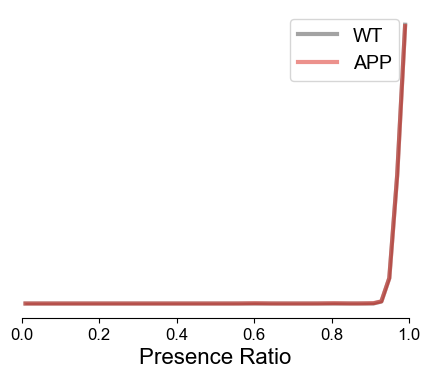

In [6]:
hists_wt = np.zeros([4,49])
hists_app = np.zeros([4,49])
wtlist = np.unique(nrndf[nrndf.geno=='WT'].animal)
applist = np.unique(nrndf[nrndf.geno=='APP'].animal)

a = 0
b = 0
for anim in animallist:
    counts, bins =  np.histogram(nrndf[nrndf.animal == anim].presrat,bins=np.linspace(0,1,50),density=True)
    x = bins[:-1] + bins[1]/2
    if anim in wtlist:
        hists_wt[a,:] = eco.smooth_1darray(counts,1,1)
        a += 1
    elif anim in applist:
        hists_app[b,:] = eco.smooth_1darray(counts,1,1)
        b += 1
        
fig, ax = plt.subplots(figsize=(5, 4))
meanwt = np.mean(hists_wt,axis=0)
semwt = np.std(hists_wt,axis=0)
meanapp = np.mean(hists_app,axis=0)
semapp = np.std(hists_app,axis=0)
ax.plot(x,meanwt,color=geno_clrs['WT'],alpha=0.5,linewidth=3,label='WT')
ax.plot(x,meanapp,color=geno_clrs['APP'],alpha=0.5,linewidth=3,label='APP')
ax.fill_between(x,meanwt-semwt,meanwt+semwt,color=geno_clrs['WT'],alpha=0.2)
ax.fill_between(x,meanapp-semapp,meanapp+semapp,color=geno_clrs['APP'],alpha=0.2)

ax.set_xlabel('Presence Ratio',fontsize = 16)

plt.xticks(fontsize=12)
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# stat_stat, stat_p = kstest(nrndf[nrndf.geno == 'WT'].presrat.values,nrndf[nrndf.geno == 'APP'].presrat.values)
# ax.text(0.2,10, f"ks test: stat={np.round(stat_stat,3)}, p={np.round(stat_p,3)}")

plt.xlim(0,1)
plt.legend(fontsize=14)
if dump:
    filename = 'presrat_by_geno.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass
plt.show()

<h1>Panel B: Unit yield across region and genotype</h1>

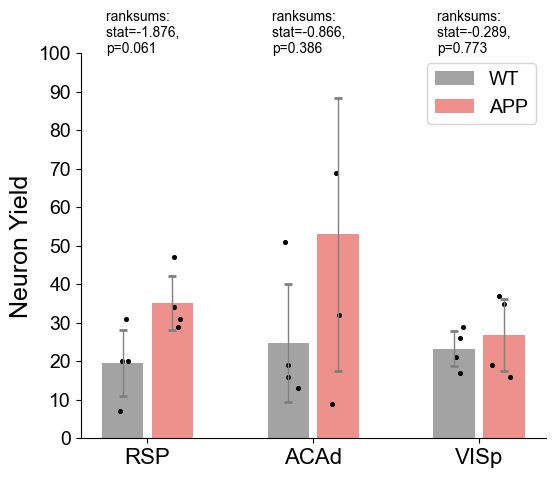

In [7]:
regions = ['RSC','ACC','V1']

colnames=['animal','geno','region','nrn_count','rsu_count','fs_count']
nrnarray = np.zeros([len(animallist)*len(regions),len(colnames)])
nrndf = pd.DataFrame(nrnarray,columns = colnames)
dfind = 0

for animal in animallist:

    a = animallist.index(animal)
    date = datelist[a]
    epoch = epochlist[a]
    cond = condlist[a]

    if cond == 'WT':
        n_animal = eco.nrnlist_by_animal(n_wt,animal)
    elif cond == 'APP':
        n_animal = eco.nrnlist_by_animal(n_app,animal)

    for r,reg in enumerate(regions):
        nrnlist_reg = eco.nrnlist_by_region(n_animal,reg)
        nrn_count = len(nrnlist_reg)
        rsu_count = len(eco.nrnlist_by_celltype(nrnlist_reg,'RSU'))
        fs_count = len(eco.nrnlist_by_celltype(nrnlist_reg,'FS'))
        nrndf.iloc[dfind] = [animal,cond,reg,nrn_count,rsu_count,fs_count]
        dfind += 1

regions = ['RSC','ACC','V1']
uniqcond = np.array(['WT','APP'])

peak_mean = np.zeros(len(regions)*2)
peak_sem = np.zeros(len(regions)*2)
count = 0
#for every condition and comparison, i.e. bar in the barplot
for reg in regions:
    for cond in uniqcond:
        bar_cond = cond
        n_animals = len(np.unique(nrndf[nrndf.geno==bar_cond].animal))
        bar_peaks = nrndf[(nrndf.geno==bar_cond)&(nrndf.region==reg)].nrn_count.values
        if np.sum(np.isnan(bar_peaks)) > 0:
            print('found nans')
#         bar_sem = np.nanstd(bar_peaks) / n_animals
        bar_sem = np.nanstd(bar_peaks)
        peak_mean[count] = np.nanmean(bar_peaks)
        peak_sem[count] = bar_sem
        count += 1

###PLOT
fig, ax = plt.subplots(figsize=(6, 5))
xpos = 0

for i,comp in enumerate(regions):
    for j,cond in enumerate(uniqcond):
        if j == 0:
            xfudge = 0.2
        elif j == 1:
            xfudge = -0.2

        ax.bar(xpos + xfudge,peak_mean[xpos],yerr = peak_sem[xpos],
               color = geno_clrs[cond],alpha=0.5, align='center', width=0.5,
               error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=2))

        plt_pts = nrndf[(nrndf.geno==cond)&(nrndf.region==comp)].nrn_count.values
        plt_pts = plt_pts[~np.isnan(plt_pts)]

        jitter = np.random.randn(len(plt_pts)) / 15
        ax.scatter(np.tile(xpos + xfudge,len(plt_pts))+jitter,
                    plt_pts,s=7,c='black',alpha=1,label='_nolegend_')
        xpos += 1

    stat_stat, stat_p = ranksums(nrndf[(nrndf.geno=='WT')&(nrndf.region==comp)].nrn_count.values,
                                 nrndf[(nrndf.geno=='APP')&(nrndf.region==comp)].nrn_count.values)
    ax.text(xpos-2,100, f"ranksums: \nstat={np.round(stat_stat,3)}, \np={np.round(stat_p,3)}")


xtickpos = np.arange(0,len(regions)*2,2)
ax.set_ylabel('Neuron Yield',fontsize = 18)
ax.set_xlabel('')
ax.get_xaxis().set_ticks(xtickpos+0.5)
ax.get_xaxis().set_ticklabels(['RSP','ACAd','VISp'],fontsize=16)
ytickpos = np.arange(0,101,10)
ax.get_yaxis().set_ticks(ytickpos)
ax.get_yaxis().set_ticklabels(ytickpos,fontsize=14)
ax.set_ylim(0,100)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['WT','APP'],fontsize=14)

filename = 'nrnyield_by_geno.pdf'

if dump:
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass
plt.show()